In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#from BFM.MCMC_MGP import Gibbs_sampling
#from BFM.MCMC_CSP import Gibbs_sampling
from BFM.MCMC_LH import Gibbs_sampling
from BFM.VI import NGVI
from BFM.utils import FDR_FNR_mcmc, FDR_FNR_VI, FDR_FNR_COV, ESS

In [2]:
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
P = 1956
K = 5
N = 100

In [4]:
B_0 = np.zeros((P, K))
for j in range(K):
    for i in range(364 * j, 364 * j + 500):
        B_0[i, j] = 1
cov_0 = B_0 @ B_0.T + np.eye(P)

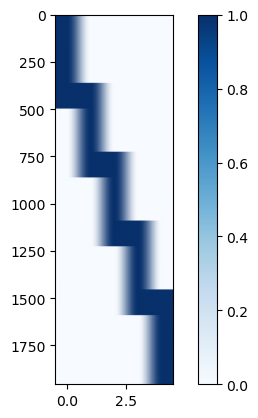

In [5]:
plt.imshow(B_0, cmap='Blues', aspect = 0.008)
plt.colorbar()
plt.show()

In [6]:
X = np.random.multivariate_normal(np.zeros(P), cov_0, N)

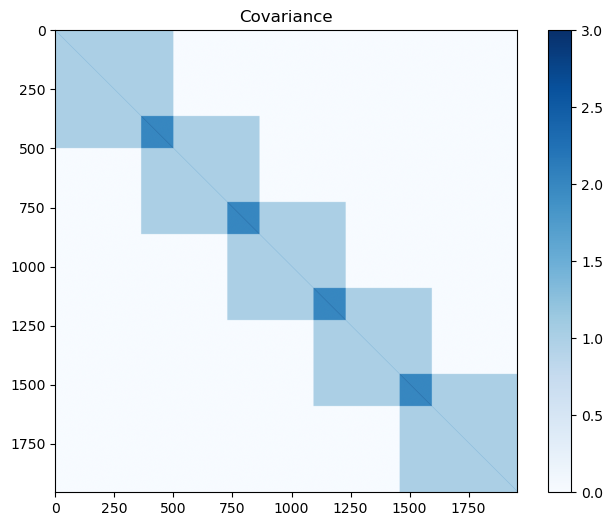

In [7]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_0, cmap='Blues')
plt.colorbar()
plt.title("Covariance")
plt.show()

In [8]:
B_sample, sigma2_sample = Gibbs_sampling(X, device = device1)

100%|██████████| 9999/9999 [27:41<00:00,  6.02it/s]


In [9]:
mu, Cov, np_sigma, v = NGVI(X, device = device1)

100%|██████████| 10/10 [00:49<00:00,  4.94s/it]


In [10]:
cov_VI = mu @ mu.T + (v / (v - 2)) * torch.diag(torch.vmap(torch.trace)(Cov)) + torch.diag(np_sigma / (0.5 * N))

In [11]:
cov_mcmc = torch.einsum('bij,bjk->ik',B_sample, B_sample.transpose(1,2)) / B_sample.size(0) + torch.diag(sigma2_sample.mean(0))

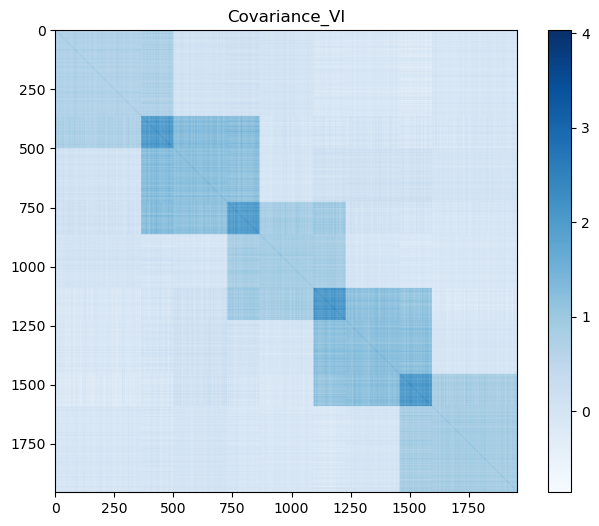

In [12]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_VI,cmap='Blues')
plt.colorbar()
plt.title("Covariance_VI")
plt.show()

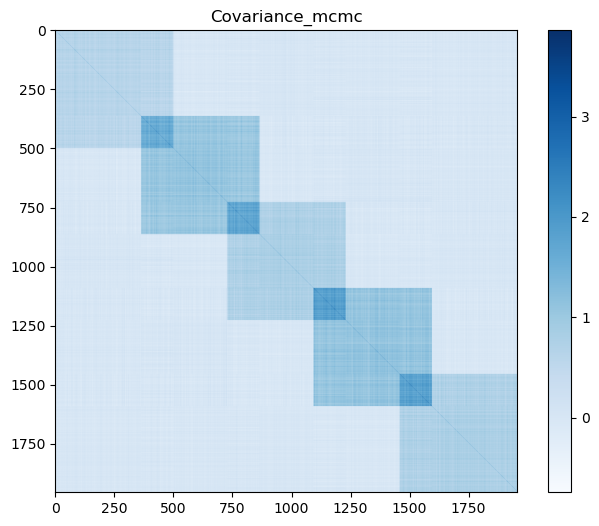

In [13]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_mcmc,cmap='Blues')
plt.colorbar()
plt.title("Covariance_mcmc")
plt.show()

[]

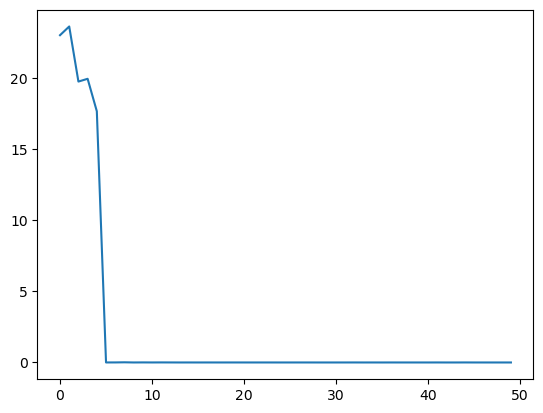

In [14]:
B_mean = B_sample.mean(0)
plt.plot(torch.norm(B_mean, dim = 0).numpy())
plt.plot()

[]

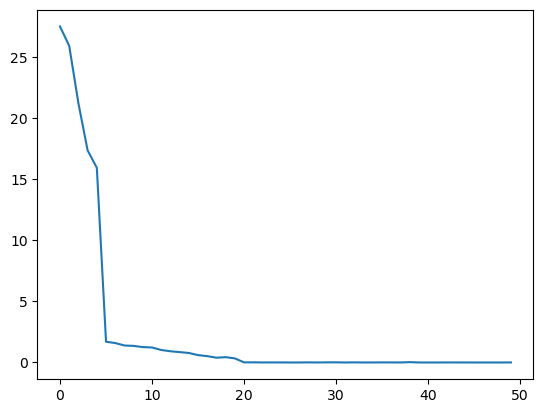

In [15]:
plt.plot(torch.norm(mu, dim = 0).numpy())
plt.plot()

In [16]:
_, _, num_K_mcmc = FDR_FNR_mcmc(B_sample, B_0)

In [17]:
_, _, num_K_VI = FDR_FNR_VI(mu, Cov, v, B_0)

In [18]:
(torch.from_numpy(cov_0) - cov_VI).square().sum().sqrt()

tensor(397.5592, dtype=torch.float64)

In [19]:
(torch.from_numpy(cov_0) - cov_mcmc).square().sum().sqrt()


tensor(345.6124, dtype=torch.float64)

In [20]:
FDR_COV_mcmc, FNR_COV_mcmc= FDR_FNR_COV(cov_0, cov_mcmc.numpy())

In [21]:
FDR_COV_VI, FNR_COV_VI= FDR_FNR_COV(cov_0, cov_VI.numpy())

In [22]:
print(FDR_COV_mcmc)
print(FNR_COV_mcmc)

0.6927765353977137
0.0


In [23]:
print(FDR_COV_VI)
print(FNR_COV_VI)

0.6928818141961919
0.0


In [24]:
ess_B = ESS(B_sample.numpy())

In [ ]:
ess_sigma2 = ESS(sigma2_sample.numpy())

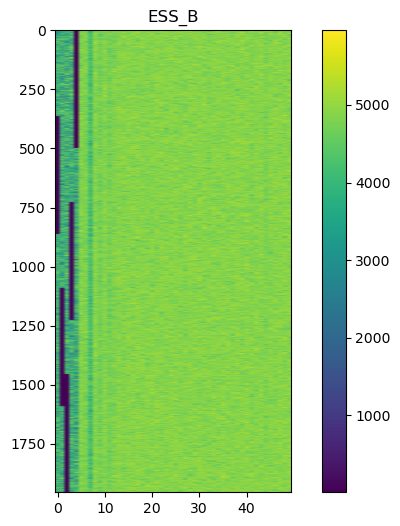

In [26]:
plt.figure(figsize=(8, 6))
plt.imshow(ess_B, aspect = 0.05)
plt.colorbar()
plt.title("ESS_B")
plt.show()